In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mlg-ulb/creditcardfraud
!unzip creditcardfraud.zip

Saving kaggle.json to kaggle.json
 70% 46.0M/66.0M [00:00<00:00, 76.0MB/s]
100% 66.0M/66.0M [00:00<00:00, 112MB/s] 
Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [ ]:
from matplotlib.colors import Normalize
import pandas as pd
from pandas.core.frame import DataFrame 
import numpy as np 
from matplotlib import pyplot as plt 
from sklearn.utils import shuffle
import seaborn as sns
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score,classification_report,precision_score,recall_score,matthews_corrcoef,make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, ADASYN,RandomOverSampler,BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler,TomekLinks,NearMiss
from imblearn.combine import SMOTETomek
from matplotlib import gridspec
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
def PCA_ALGO(X,y):
    #PREPARATION DES DONNEES
    NEW_X=pd.DataFrame(data=X,columns=colonnes_X)
    NEW_X['Class']=pd.DataFrame(data=y,columns=colonnes_Y)
    X=shuffle(NEW_X)
    y=X.iloc[:,-1].values

    pca = PCA(n_components=2)
    pca_data=pca.fit_transform(X)
    print(pca_data.shape)
    pca_data=np.vstack((pca_data.T,y)).T
    print(pca_data.shape)
    print(pca_data)
    pca_df=pd.DataFrame(data=pca_data,columns=('PCA1','PCA2','Classe'))
    sns.FacetGrid(pca_df,hue='Classe',size=6).map(plt.scatter,'PCA1','PCA2').add_legend()
    plt.show()

def Distribution(X,y):
    #PREPARATION DES DONNEES
    tsne = TSNE(n_components=2,learning_rate=100,perplexity=50.0,early_exaggeration=20.0,init='pca')
    NEW_X=pd.DataFrame(data=X,columns=colonnes_X)
    NEW_X['Class']=pd.DataFrame(data=y,columns=colonnes_Y)
    #SNS COUNTPLOT
    fig,ax=plt.subplots(figsize=(5,5))
    sns.countplot(data=NEW_X,x="Class")
    plt.show()
def TSNE_algo(X,y):

    #PREPARATION DES DONNEES
    tsne = TSNE(n_components=2,learning_rate=100,perplexity=50.0,early_exaggeration=20.0,init='pca')
    NEW_X=pd.DataFrame(data=X,columns=colonnes_X)
    NEW_X['Class']=pd.DataFrame(data=y,columns=colonnes_Y)
    Fraude=NEW_X[NEW_X['Class']==1]
    Normal=NEW_X[NEW_X['Class']==0]
    Normal=Normal.iloc[0:10000] #pour prendre que 10000 transaction normale
    X=pd.concat([Normal,Fraude])
    X=shuffle(X)
    y=X.iloc[:,-1].values

    #TSNE
    x_test_2d = tsne.fit_transform(X)
    color_map = {0:'green', 1:'red'}
    plt.figure()
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x = x_test_2d[y==cl,0], 
                    y = x_test_2d[y==cl,1], 
                    c = color_map[idx], 
                    label = cl)
    plt.xlabel('Composant t-SNE 1')
    plt.ylabel('Composant t-SNE 2')
    plt.legend(loc='upper left')
    plt.title('Représentation des données avec T-SNE')
    plt.show()


In [ ]:
def reg_log(X_tr,y_tr,X_ts,y_ts):
    logreg = LogisticRegression()
    logreg.fit(X_tr,y_tr)
    y_pred = logreg.predict(X_ts)
    print('Accuracy :{0:0.5f}'.format(accuracy_score(y_pred, y_ts))) 
    print('Precision : {0:0.5f}'.format(precision_score(y_ts , y_pred)))
    print('Recall : {0:0.5f}'.format(recall_score(y_ts , y_pred)))
    print('F1 : {0:0.5f}'.format(f1_score(y_ts , y_pred)))
    print('matthews_corrcoef : {0:0.5f}'.format(matthews_corrcoef(y_ts , y_pred)))
    print(f"\\\\Matrice de confusion ///:- \n {confusion_matrix(y_ts, y_pred)}")
    sns.heatmap(pd.DataFrame(confusion_matrix(y_ts, y_pred)), annot=True, annot_kws={"size": 25}, cmap="winter" ,fmt='g')
    plt.title('Matrice de confusion', y=1.1, fontsize = 22)
    plt.xlabel('Prédit',fontsize = 18)
    plt.ylabel('Réel',fontsize = 18)
    plt.show()
def reg_log_opti(X_tr,y_tr,X_ts,y_ts):
    logreg = LogisticRegression()
    # Hyperparameters
    grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],'penalty':['l1','l2']}
    # KFold
    cv = KFold(n_splits=5,random_state=None,shuffle=False)
    #Scorer
    mcc_score=make_scorer(matthews_corrcoef)
    #GRID SEARCH
    log_clf=GridSearchCV(logreg, grid, cv=cv, n_jobs=-1, scoring=mcc_score)
    log_clf.fit(X_tr,y_tr)
    print("les meilleurs hyperparamètres pour la regression logistique sont :{}".format(log_clf.best_params_))
    y_pred = log_clf.predict(X_ts)
    print('Accuracy :{0:0.5f}'.format(accuracy_score(y_pred, y_ts))) 
    print('Precision : {0:0.5f}'.format(precision_score(y_ts , y_pred)))
    print('Recall : {0:0.5f}'.format(recall_score(y_ts , y_pred)))
    print('F1 : {0:0.5f}'.format(f1_score(y_ts , y_pred)))
    print('matthews_corrcoef : {0:0.5f}'.format(matthews_corrcoef(y_ts , y_pred)))
    print(f"\\\\Matrice de confusion ///:- \n {confusion_matrix(y_ts, y_pred)}")
    sns.heatmap(pd.DataFrame(confusion_matrix(y_ts, y_pred)), annot=True, annot_kws={"size": 25}, cmap="winter" ,fmt='g')
    plt.title('Matrice de confusion', y=1.1, fontsize = 22)
    plt.xlabel('Prédit',fontsize = 18)
    plt.ylabel('Réel',fontsize = 18)
    plt.show()


In [ ]:
df = pd.read_csv('creditcard.csv').astype(np.float32)
colonnes_X=['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

colonnes_Y=['Class']
Sc=StandardScaler()
Amount=df["Amount"].values
df["Amount"]=Sc.fit_transform(Amount.reshape(-1,1))
Time=df["Time"].values
df["Time"]=Sc.fit_transform(Time.reshape(-1,1))

x = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)


********** AVANT ECHANTILLONAGE **********
transactions de la dataset X_TRAIN originale =Counter({0.0: 227454, 1.0: 391})
transactions de la dataset X_TEST originale =Counter({0.0: 56861, 1.0: 101})
Accuracy :0.99919
Precision : 0.87671
Recall : 0.63366
F1 : 0.73563
matthews_corrcoef : 0.74498
\\Matrice de confusion ///:- 
 [[56852     9]
 [   37    64]]


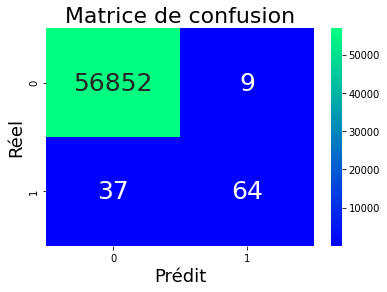

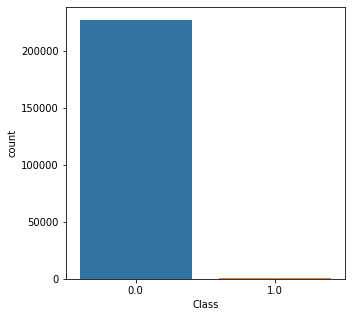

(227845, 2)
(227845, 3)
[[-2.1725974   0.44409588  0.        ]
 [-1.4108539   0.8287587   0.        ]
 [ 0.4746623   0.10218238  0.        ]
 ...
 [-2.2474136   0.64174056  0.        ]
 [ 0.6557726  -0.74884284  0.        ]
 [-1.6533008   2.281219    0.        ]]


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


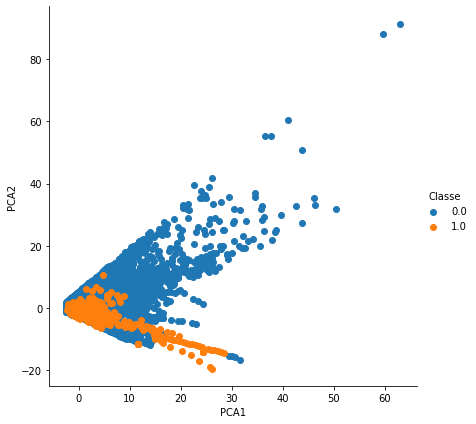

In [ ]:
# #AVANT ECHANTILLONNAGE UNDERSAMPLING
print("*"*10,"AVANT ECHANTILLONAGE","*"*10)
print("transactions de la dataset X_TRAIN originale ={}".format(Counter(Y_train)))
print("transactions de la dataset X_TEST originale ={}".format(Counter(Y_test)))
reg_log(X_train,Y_train,X_test,Y_test)
# #TSNE_algo(X_train,Y_train)
Distribution(X_train,Y_train)
PCA_ALGO(X_train,Y_train)
print("\n")

In [ ]:
print("-"*20,"TECHNIQUES DE SOUS-ECHANTILLONAGE UNDERSAMPLING","-"*20)

-------------------- TECHNIQUES DE SOUS-ECHANTILLONAGE UNDERSAMPLING --------------------


********** APRES RANDOM UNDERSAMPLING **********
transactions de la X_TRAIN dataset apres RANDOM UNDERSAMPLING=Counter({0.0: 391, 1.0: 391})
transactions de la dataset X_TEST originale =Counter({0.0: 56861, 1.0: 101})
Accuracy :0.96629
Precision : 0.04638
Recall : 0.92079


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


F1 : 0.08832
matthews_corrcoef : 0.20254
\\Matrice de confusion ///:- 
 [[54949  1912]
 [    8    93]]


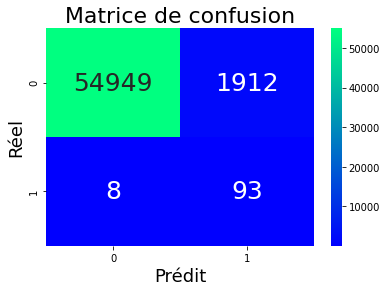

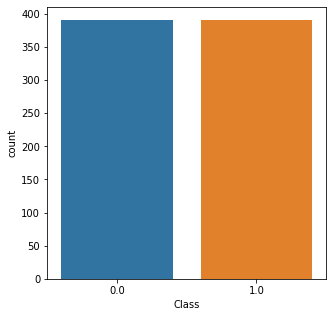

(782, 2)
(782, 3)
[[ -9.517548     0.76028335   0.        ]
 [  0.13482945  -1.6113967    1.        ]
 [ -8.835241     0.37618342   1.        ]
 ...
 [ 33.722218    -8.270605     1.        ]
 [ 31.698217   -10.230283     1.        ]
 [  1.2677294   -0.4444526    1.        ]]


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


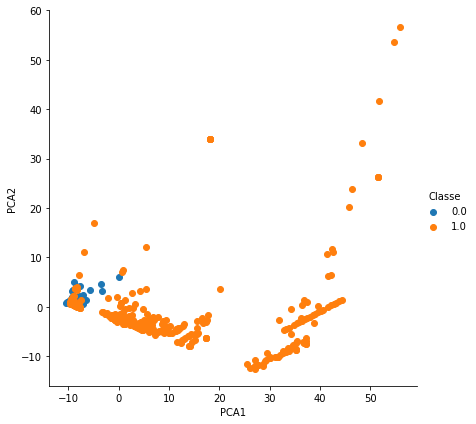

In [ ]:
# #APRES ECHANTILLONNAGE RANDOM UNDERSAMPLING
print("*"*10,"APRES RANDOM UNDERSAMPLING","*"*10)
rus=RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_resample(X_train, Y_train)
print("transactions de la X_TRAIN dataset apres RANDOM UNDERSAMPLING={}".format(Counter(y_train_rus)))
print("transactions de la dataset X_TEST originale ={}".format(Counter(Y_test)))
reg_log(X_train_rus,y_train_rus,X_test,Y_test)
Distribution(X_train_rus,y_train_rus)
#TSNE_algo(X_train_rus,y_train_rus)
PCA_ALGO(X_train_rus,y_train_rus)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


transactions de la X_TRAIN dataset apres TomekLinks=Counter({0.0: 227435, 1.0: 391})
transactions de la dataset X_TEST originale =Counter({0.0: 56861, 1.0: 101})
Accuracy :0.99923
Precision : 0.88000
Recall : 0.65347
F1 : 0.75000
matthews_corrcoef : 0.75796
\\Matrice de confusion ///:- 
 [[56852     9]
 [   35    66]]


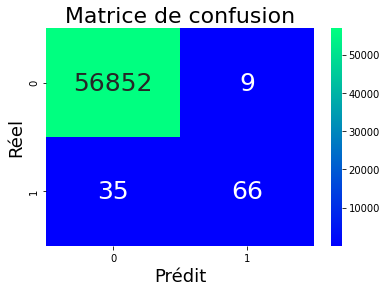

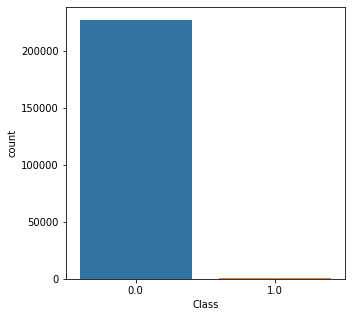

(227826, 2)
(227826, 3)
[[-1.2990705  -0.14532633  0.        ]
 [-0.87892276 -0.1214347   0.        ]
 [-2.1756964   0.5215202   0.        ]
 ...
 [ 0.64119804 -0.5535768   0.        ]
 [ 1.2148124  -1.9729279   0.        ]
 [ 0.46825272 -1.4346657   0.        ]]


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


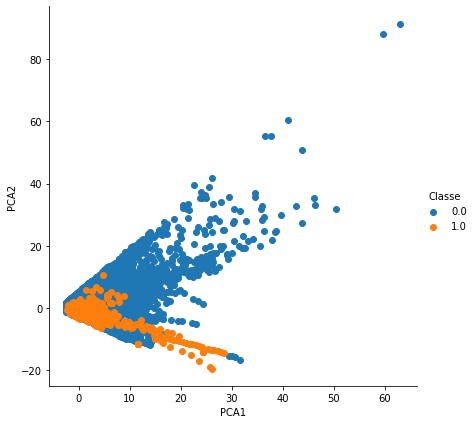

In [ ]:
#APRES ECHANTILLONNAGE TomekLinks
tl=TomekLinks()
X_train_tl, y_train_tl = tl.fit_resample(X_train, Y_train)
print("transactions de la X_TRAIN dataset apres TomekLinks={}".format(Counter(y_train_tl)))
print("transactions de la dataset X_TEST originale ={}".format(Counter(Y_test)))
reg_log(X_train_tl,y_train_tl,X_test,Y_test)
Distribution(X_train_tl,y_train_tl)
# TSNE_algo(X_train_bdsmote,y_train_bdsmote)
PCA_ALGO(X_train_tl,y_train_tl)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


transactions de la X_TRAIN dataset apres NearMiss=Counter({0.0: 227435, 1.0: 391})
transactions de la dataset X_TEST originale =Counter({0.0: 56861, 1.0: 101})
Accuracy :0.99923
Precision : 0.88000
Recall : 0.65347
F1 : 0.75000
matthews_corrcoef : 0.75796
\\Matrice de confusion ///:- 
 [[56852     9]
 [   35    66]]


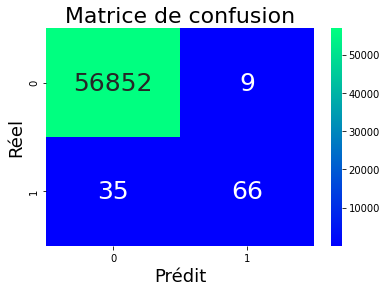

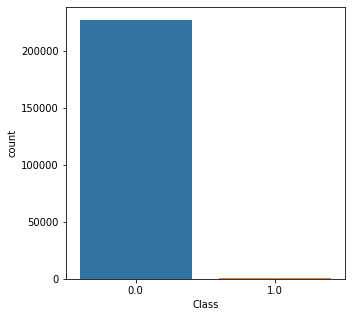

(227826, 2)
(227826, 3)
[[-1.3949255   0.9254372   0.        ]
 [ 1.1322002  -1.2143043   0.        ]
 [ 0.32777253 -1.5575202   0.        ]
 ...
 [-1.9973538   0.44000426  0.        ]
 [ 0.33910385 -1.2923665   0.        ]
 [-1.6421078   0.49595368  0.        ]]


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


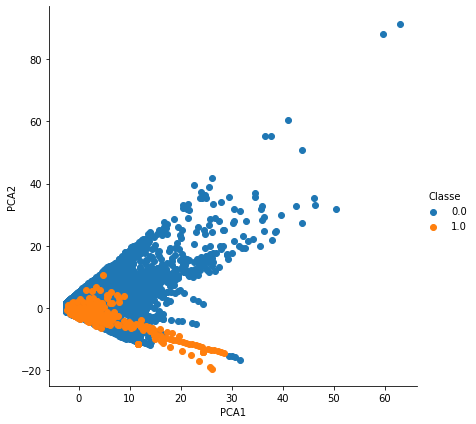

In [ ]:
#APRES ECHANTILLONNAGE NearMiss
nm=TomekLinks()
X_train_nm, y_train_nm = nm.fit_resample(X_train, Y_train)
print("transactions de la X_TRAIN dataset apres NearMiss={}".format(Counter(y_train_nm)))
print("transactions de la dataset X_TEST originale ={}".format(Counter(Y_test)))
#random_forest_classifier(X_train_smt,y_train_smt,X_test,Y_test)
reg_log(X_train_nm,y_train_nm,X_test,Y_test)
Distribution(X_train_nm,y_train_nm)
# TSNE_algo(X_train_bdsmote,y_train_bdsmote)
PCA_ALGO(X_train_nm,y_train_nm)

In [ ]:
print("-"*20,"TECHNIQUES DE SUR-ECHANTILLONAGE OVERSAMPLING","-"*20)

-------------------- TECHNIQUES DE SUR-ECHANTILLONAGE OVERSAMPLING --------------------


********** APRES RANDOM OVERSAMPLING **********
transactions de la X_TRAIN dataset apres RANDOM OVERSAMPLING=Counter({0.0: 227454, 1.0: 227454})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


transactions de la dataset X_TEST originale =Counter({0.0: 56861, 1.0: 101})
Accuracy :0.97705
Precision : 0.06805
Recall : 0.94059
F1 : 0.12692
matthews_corrcoef : 0.24971
\\Matrice de confusion ///:- 
 [[55560  1301]
 [    6    95]]


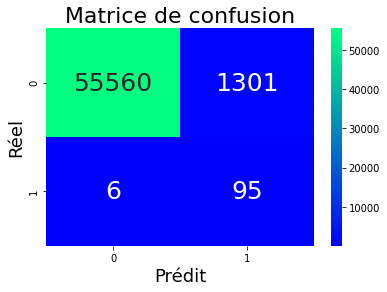

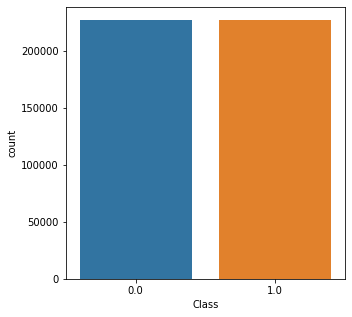

(454908, 2)
(454908, 3)
[[ -9.063571    1.200639    0.       ]
 [ -9.54908     1.5811343   1.       ]
 [ 27.828878  -11.550138    1.       ]
 ...
 [ -8.923155    0.342557    1.       ]
 [  4.976909   -2.9707806   1.       ]
 [  2.0696666  -3.200659    1.       ]]


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


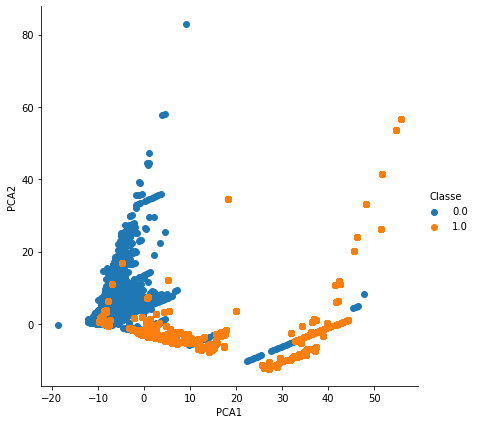

In [ ]:
# # #APRES ECHANTILLONNAGE RANDOM OVERSAMPLING

print("*"*10,"APRES RANDOM OVERSAMPLING","*"*10)
ros=RandomOverSampler()
X_train_ros, y_train_ros = ros.fit_resample(X_train, Y_train)
print("transactions de la X_TRAIN dataset apres RANDOM OVERSAMPLING={}".format(Counter(y_train_ros)))
print("transactions de la dataset X_TEST originale ={}".format(Counter(Y_test)))
reg_log(X_train_ros,y_train_ros,X_test,Y_test)
Distribution(X_train_ros,y_train_ros)
#TSNE_algo(X_train_ros,y_train_ros)
PCA_ALGO(X_train_ros,y_train_ros)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


transactions de la X_TRAIN dataset apres SMOTE=Counter({0.0: 227454, 1.0: 227454})
transactions de la dataset X_TEST originale =Counter({0.0: 56861, 1.0: 101})
Accuracy :0.97493
Precision : 0.06262
Recall : 0.94059
F1 : 0.11743
matthews_corrcoef : 0.23925
\\Matrice de confusion ///:- 
 [[55439  1422]
 [    6    95]]


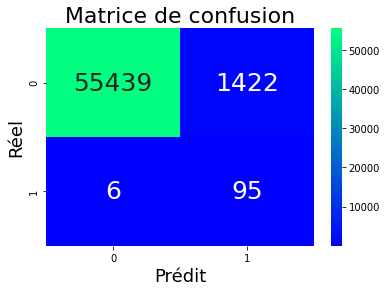

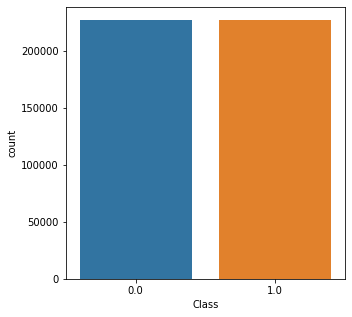

(454908, 2)
(454908, 3)
[[-8.437232    1.3143584   0.        ]
 [-9.535547    0.6667468   1.        ]
 [-9.44476     0.662406    0.        ]
 ...
 [-9.558979    0.77298737  0.        ]
 [ 0.16767405 -2.2066486   1.        ]
 [-8.370412    1.4113246   0.        ]]


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


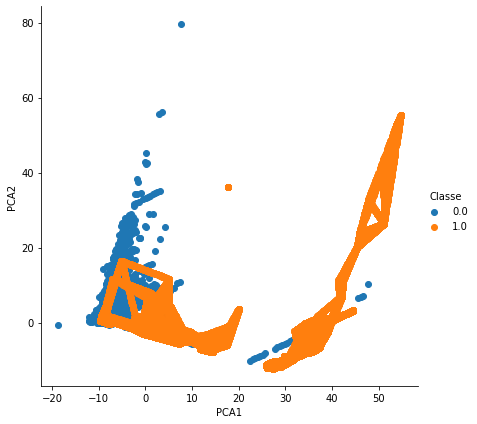

In [ ]:
#APRES ECHANTILLONNAGE SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, Y_train)
print("transactions de la X_TRAIN dataset apres SMOTE={}".format(Counter(y_train_smote)))
print("transactions de la dataset X_TEST originale ={}".format(Counter(Y_test)))
reg_log(X_train_smote,y_train_smote,X_test,Y_test)
Distribution(X_train_smote,y_train_smote)
# TSNE_algo(X_train_smote,y_train_smote)
PCA_ALGO(X_train_smote,y_train_smote)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


transactions de la X_TRAIN dataset apres ADASYN=Counter({1.0: 227476, 0.0: 227454})
transactions de la dataset X_TEST originale =Counter({0.0: 56861, 1.0: 101})
Accuracy :0.90603
Precision : 0.01799
Recall : 0.97030
F1 : 0.03532
matthews_corrcoef : 0.12534
\\Matrice de confusion ///:- 
 [[51511  5350]
 [    3    98]]


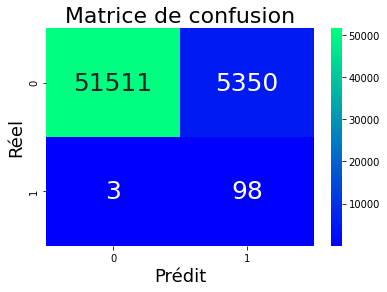

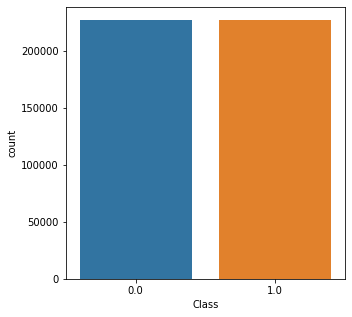

(454930, 2)
(454930, 3)
[[-2.5084772   0.9050381   0.        ]
 [-2.0878074   3.0418558   0.        ]
 [ 7.5350494  -0.10402893  1.        ]
 ...
 [-2.712564    0.21595046  1.        ]
 [-2.393324    1.9802355   0.        ]
 [-2.31792    -0.97921604  1.        ]]


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


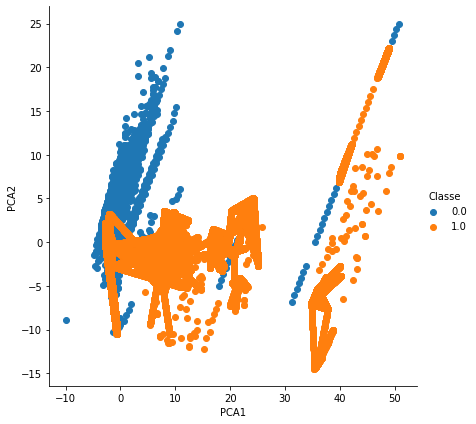

In [ ]:
##APRES ECHANTILLONNAGE ADASYN
adasyn = ADASYN()
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, Y_train)
print("transactions de la X_TRAIN dataset apres ADASYN={}".format(Counter(y_train_adasyn)))
print("transactions de la dataset X_TEST originale ={}".format(Counter(Y_test)))
reg_log(X_train_adasyn,y_train_adasyn,X_test,Y_test)
Distribution(X_train_adasyn,y_train_adasyn)
# TSNE_algo(X_train_adasyn,y_train_adasyn)
PCA_ALGO(X_train_adasyn,y_train_adasyn)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


transactions de la X_TRAIN dataset apres BorderlineSMOTE=Counter({0.0: 227454, 1.0: 227454})
transactions de la dataset X_TEST originale =Counter({0.0: 56861, 1.0: 101})


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy :0.98425
Precision : 0.09221
Recall : 0.89109
F1 : 0.16713
matthews_corrcoef : 0.28383
\\Matrice de confusion ///:- 
 [[55975   886]
 [   11    90]]


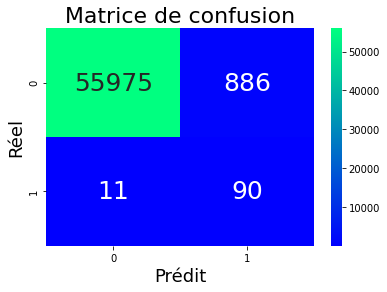

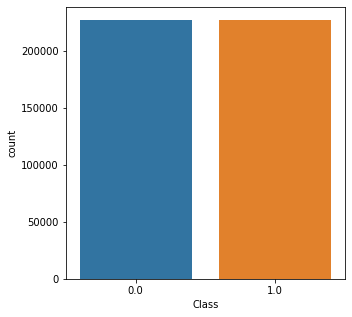

(454908, 2)
(454908, 3)
[[-4.5978327  -2.8088381   0.        ]
 [-5.3454146  -2.6985788   0.        ]
 [-5.275837   -2.9280422   0.        ]
 ...
 [-5.062911   -0.6392888   0.        ]
 [35.42882    -0.27315044  1.        ]
 [ 5.2205086   7.930759    1.        ]]


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


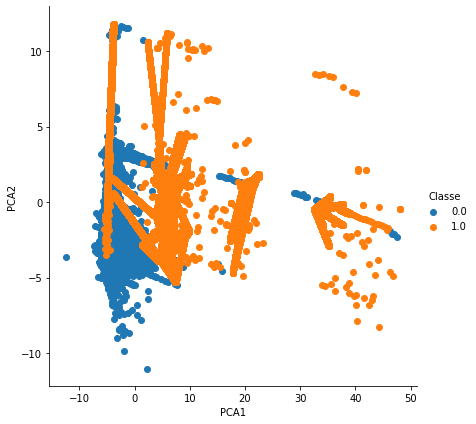

In [ ]:
# #APRES ECHANTILLONNAGE BorderlineSMOTE
bdsmote = BorderlineSMOTE()
X_train_bdsmote, y_train_bdsmote = bdsmote.fit_resample(X_train, Y_train)
print("transactions de la X_TRAIN dataset apres BorderlineSMOTE={}".format(Counter(y_train_bdsmote)))
print("transactions de la dataset X_TEST originale ={}".format(Counter(Y_test)))
reg_log(X_train_bdsmote,y_train_bdsmote,X_test,Y_test)
Distribution(X_train_bdsmote,y_train_bdsmote)
# TSNE_algo(X_train_bdsmote,y_train_bdsmote)
PCA_ALGO(X_train_bdsmote,y_train_bdsmote)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


transactions de la X_TRAIN dataset apres SMOTETOmek=Counter({0.0: 227454, 1.0: 227454})
transactions de la dataset X_TEST originale =Counter({0.0: 56861, 1.0: 101})
Accuracy :0.97484
Precision : 0.06242
Recall : 0.94059
F1 : 0.11707
matthews_corrcoef : 0.23884
\\Matrice de confusion ///:- 
 [[55434  1427]
 [    6    95]]


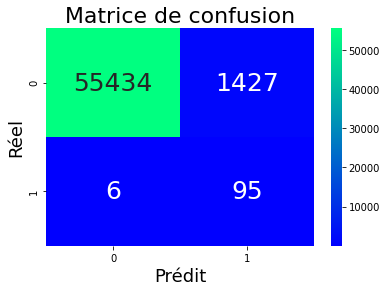

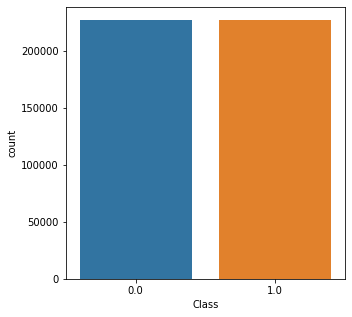

(454908, 2)
(454908, 3)
[[-9.544384    1.0339347   0.        ]
 [13.903617   -6.0288053   1.        ]
 [-0.46713918 -1.6190103   1.        ]
 ...
 [-9.456178    0.66574955  0.        ]
 [-9.094451    1.4736187   0.        ]
 [-9.611961    0.90633905  0.        ]]


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


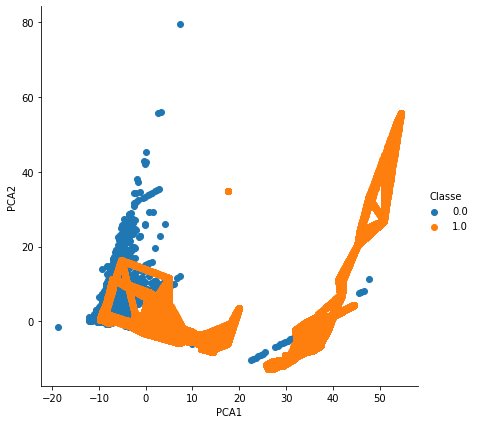

In [ ]:
smt = SMOTETomek()
X_train_smt, y_train_smt = smt.fit_resample(X_train, Y_train)
print("transactions de la X_TRAIN dataset apres SMOTETOmek={}".format(Counter(y_train_smt)))
print("transactions de la dataset X_TEST originale ={}".format(Counter(Y_test)))
reg_log(X_train_smt,y_train_smt,X_test,Y_test)
Distribution(X_train_smt,y_train_smt)
# TSNE_algo(X_train_bdsmote,y_train_bdsmote)
PCA_ALGO(X_train_smt,y_train_smt)